In [1]:
!pip install pandas opencv-python matplotlib scikit-learn


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


The dataset has 43 classes of different traffic signs.

The zip file Has 3 folders and 3 csv files:

Train.csv & Test.csv- Contains information about train and test images respectively. Information includes- Width & Height of image. X & Y coordinate of top left and bottom right corner of ROI in the image, which class the image belongs to and the path to the image.
Meta.csv- contains info about the metadata. Information includes path of the image, which class it belongs to, what is the shape of the sign (traingle/circle/etc.), what is the color of the sign.

In the meta folder it contains sample picture of each sign.
The test folder contains 12,631 images for testing purposes.
The train folder contains 43 subfolders which have different number of images for each class for training purposes.

In [2]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import seaborn as sns
import pywt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler #
from sklearn.pipeline import Pipeline #
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import hog
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.model_selection import train_test_split #import all libraries.

INITIAL EXPLORATION

In [3]:
#data loaded
dataset_path = r"C:\Users\aakaash\OneDrive\Desktop\QMUL\Project\PROJECT\archive"

In [4]:
meta_df = pd.read_csv(os.path.join(dataset_path, 'Meta.csv'))
train_df = pd.read_csv(os.path.join(dataset_path, 'Train.csv'))
test_df = pd.read_csv(os.path.join(dataset_path, 'Test.csv'))

In [5]:
print(meta_df.head())

          Path  ClassId  ShapeId  ColorId SignId
0  Meta/27.png       27        0        0   1.32
1   Meta/0.png        0        1        0   3.29
2   Meta/1.png        1        1        0   3.29
3  Meta/10.png       10        1        0   3.27
4  Meta/11.png       11        0        0   1.22


In [6]:
print(train_df.tail())

       Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
39204     52      56       5       6      47      51       42   
39205     56      58       5       5      51      53       42   
39206     58      62       5       6      53      57       42   
39207     63      69       5       7      58      63       42   
39208     68      69       7       6      62      63       42   

                                 Path  
39204  Train/42/00042_00007_00025.png  
39205  Train/42/00042_00007_00026.png  
39206  Train/42/00042_00007_00027.png  
39207  Train/42/00042_00007_00028.png  
39208  Train/42/00042_00007_00029.png  


In [7]:
print(test_df.head())

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png


In [8]:
print("\nTraining Set Info:")
print(train_df.info())
print("\nTesting Set Info:")
print(test_df.info())


Training Set Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path     39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB
None

Testing Set Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12630 entries, 0 to 12629
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    12630 non-null  int64 
 1   Height   12630 non-null  int64 
 2   Roi.X1   12630 non-null  int64 
 3   Roi.Y1   12630 non-null  int64 
 4   Roi.X2   12630 non-null  int64 
 5   Roi.Y2   12630 non-null  int64 
 6   ClassId  12630 non-


Training Set Label Counts:
ClassId
0      210
1     2220
2     2250
3     1410
4     1980
5     1860
6      420
7     1440
8     1410
9     1470
10    2010
11    1320
12    2100
13    2160
14     780
15     630
16     420
17    1110
18    1200
19     210
20     360
21     330
22     390
23     510
24     270
25    1500
26     600
27     240
28     540
29     270
30     450
31     780
32     240
33     689
34     420
35    1200
36     390
37     210
38    2070
39     300
40     360
41     240
42     240
Name: count, dtype: int64


C:\Users\aakaash\AppData\Local\Temp\ipykernel_13688\1932715358.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_yticklabels(barplot.get_yticklabels(), fontsize=20)


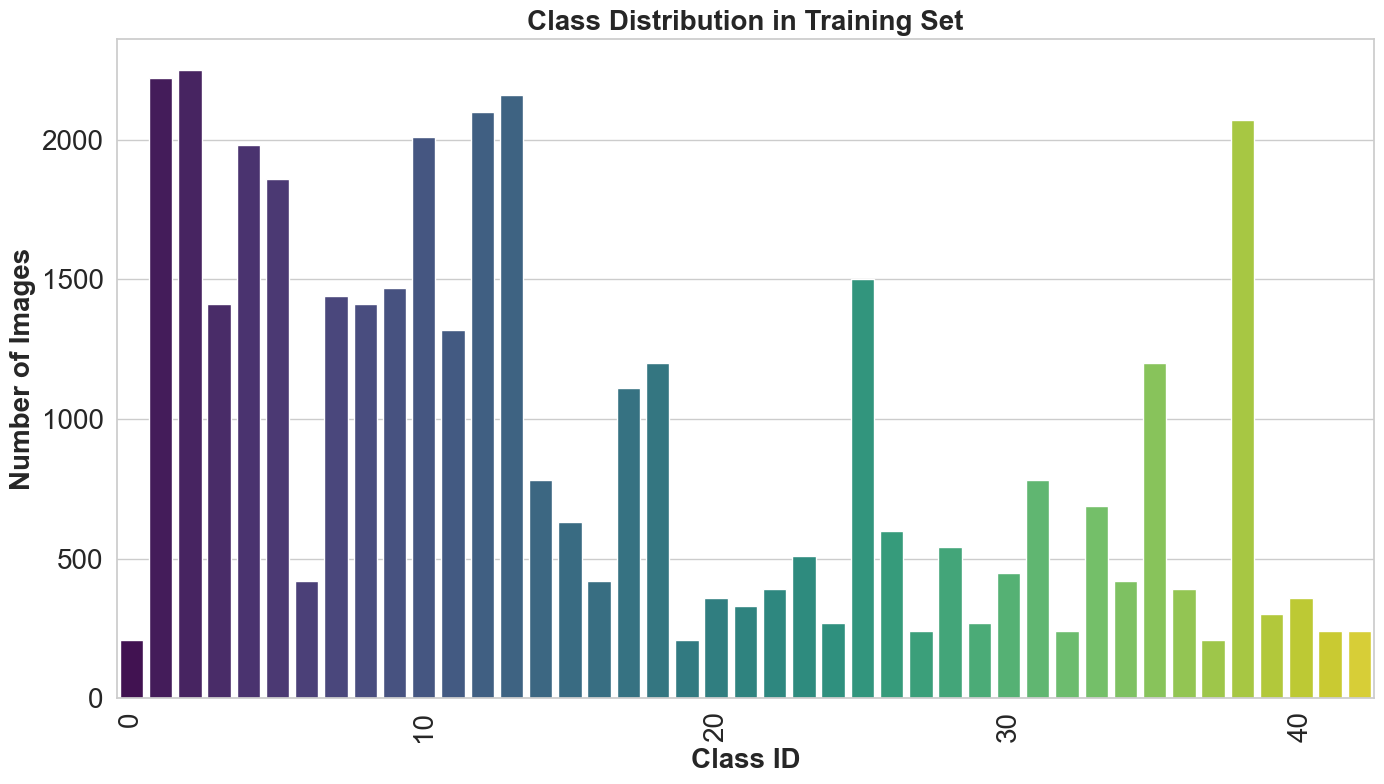

In [18]:
#check and plot the dist of classes
train_label_counts = train_df['ClassId'].value_counts().sort_index()
print("\nTraining Set Label Counts:")
print(train_label_counts)

plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
barplot = sns.barplot(x=train_label_counts.index, y=train_label_counts.values, palette="viridis")
barplot.set_title("Class Distribution in Training Set", fontsize=20, weight='bold')
barplot.set_xlabel("Class ID", fontsize=20, weight='bold')
barplot.set_ylabel("Number of Images", fontsize=20, weight='bold')
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90, fontsize=20)
barplot.set_yticklabels(barplot.get_yticklabels(), fontsize=20)

plt.xticks(ticks=range(0, max(train_label_counts.index) + 1, 10), fontsize=20)
plt.tight_layout()
plt.show()

Can see some class imbalance here.

In [10]:
#to load images
def load_images(df, base_path):
    images = []
    labels = []
    for index, row in df.iterrows():
        img_path = os.path.join(base_path, row['Path'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  #convertt to RGB
        images.append(img)
        labels.append(row['ClassId'])
    return images, labels

In [11]:
train_images, train_labels = load_images(train_df, dataset_path) #loading train images and labels
test_images, test_labels = load_images(test_df, dataset_path) #loading test images and labels

In [12]:
print(f"Loaded {len(train_images)} training images and {len(train_labels)} labels.")
print(f"Loaded {len(test_images)} test images and {len(test_labels)} labels.")

Loaded 39209 training images and 39209 labels.
Loaded 12630 test images and 12630 labels.


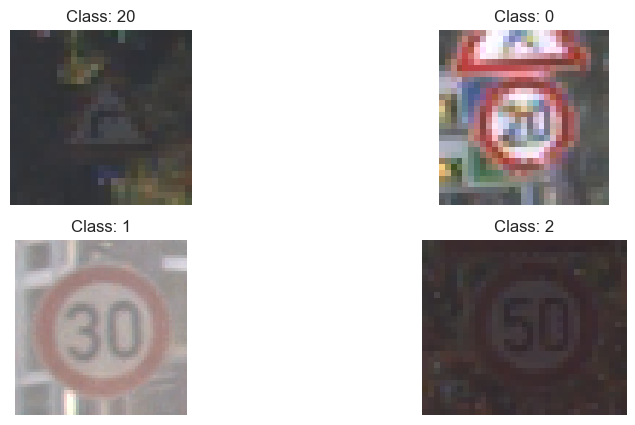

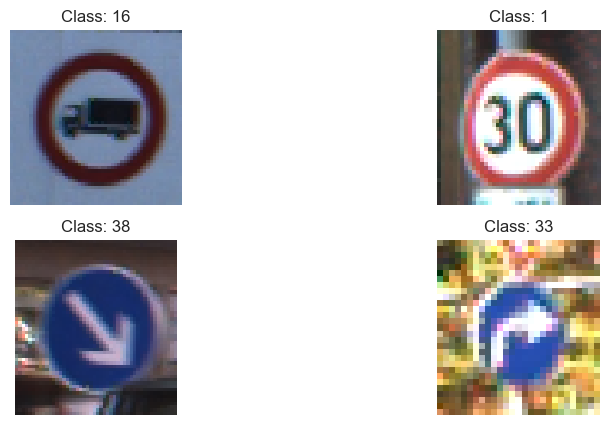

In [15]:
def display_different_class_images(images, labels, num_classes=4):
    unique_classes = list(set(labels))  #get unique class labels
    random.shuffle(unique_classes)  
    
    plt.figure(figsize=(10, 5))  
    displayed_classes = 0
    class_to_image = {}
    
    for img, lbl in zip(images, labels):
        if lbl not in class_to_image:
            class_to_image[lbl] = img
            displayed_classes += 1
            if displayed_classes >= num_classes:
                break

    for i, (lbl, img) in enumerate(class_to_image.items()):
        plt.subplot(2, 2, i + 1)  
        plt.imshow(img)
        plt.title(f"Class: {lbl}")
        plt.axis('off')
    plt.show()

display_different_class_images(train_images, train_labels, num_classes=4)
display_different_class_images(test_images, test_labels, num_classes=4)

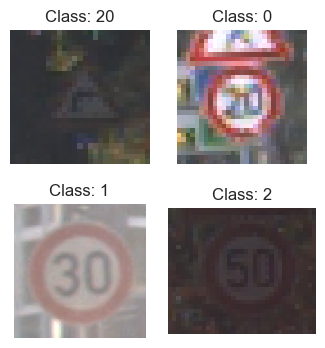

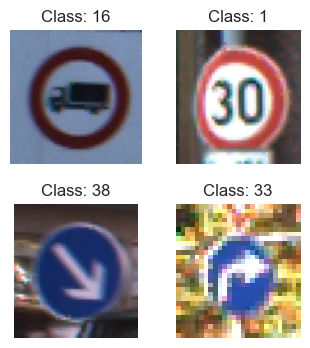

In [14]:
def display_images(images, labels, num_classes=4):
    unique_classes = list(set(labels))  #get unique class labels
    random.shuffle(unique_classes)
    
    plt.figure(figsize=(4,4))  
    displayed_classes = 0
    class_to_image = {}
    
    for img, lbl in zip(images, labels):
        if lbl not in class_to_image:
            class_to_image[lbl] = img
            displayed_classes += 1
            if displayed_classes >= num_classes:
                break

    for i, (lbl, img) in enumerate(class_to_image.items()):
        plt.subplot(2, 2, i + 1)
        plt.imshow(img)
        plt.title(f"Class: {lbl}")
        plt.axis('off')
    
    plt.subplots_adjust(wspace=0.1, hspace=0.3)  
    plt.show()

display_images(train_images, train_labels, num_classes=4)
display_images(test_images, test_labels, num_classes=4)

In [16]:
def resize_images(images, size=(32, 32)):
    resized_images = [cv2.resize(img, size) for img in images]
    return resized_images

def normalize_images(images):
    normalized_images = [img / 255.0 for img in images]
    return normalized_images

def reduce_noise(images, kernel_size=(5, 5)): #testing with this - removing this as it gives better performance
    denoised_images = [cv2.GaussianBlur(img, kernel_size, 0) for img in images]
    return denoised_images 

In [17]:
#train_images = reduce_noise(train_images)
#test_images = reduce_noise(test_images)
train_images = resize_images(train_images, size=(32, 32))
test_images = resize_images(test_images, size=(32, 32))
train_images = normalize_images(train_images)
test_images = normalize_images(test_images)

In [18]:
train_images = np.array(train_images)
test_images = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [19]:
'''X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42) #split trainnset into train and validation'''

'X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42) #split trainnset into train and validation'

In [20]:
#stratified splitting
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in sss.split(train_images, train_labels):
    X_train, X_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

In [21]:
print(f"Train images shape: {X_train.shape}")
print(f"Validation images shape: {X_val.shape}")
print(f"Test images shape: {test_images.shape}")

Train images shape: (31367, 32, 32, 3)
Validation images shape: (7842, 32, 32, 3)
Test images shape: (12630, 32, 32, 3)


In [22]:
def show_images(images, labels, num=5):
    plt.figure(figsize=(10, 5))
    random_indices = random.sample(range(len(images)), num)
    for i, idx in enumerate(random_indices):
        plt.subplot(1, num, i+1)
        plt.imshow(images[idx])
        plt.title(f"Label: {labels[idx]}")
        plt.axis('off')
    plt.show()

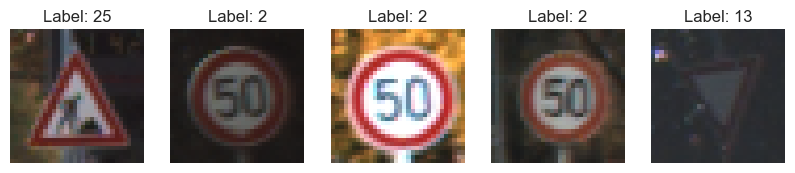

In [23]:
show_images(train_images, train_labels) #display train img after pre processing

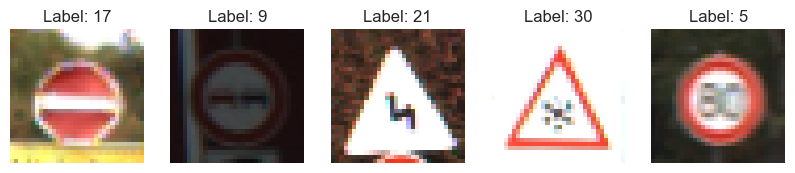

In [24]:
show_images(test_images, test_labels) #display test img after pre processing

In [25]:
train_label_counts = train_df['ClassId'].value_counts().sort_index()
print("Training set label counts:")
print(train_label_counts)

Training set label counts:
ClassId
0      210
1     2220
2     2250
3     1410
4     1980
5     1860
6      420
7     1440
8     1410
9     1470
10    2010
11    1320
12    2100
13    2160
14     780
15     630
16     420
17    1110
18    1200
19     210
20     360
21     330
22     390
23     510
24     270
25    1500
26     600
27     240
28     540
29     270
30     450
31     780
32     240
33     689
34     420
35    1200
36     390
37     210
38    2070
39     300
40     360
41     240
42     240
Name: count, dtype: int64


In [26]:
test_label_counts = test_df['ClassId'].value_counts().sort_index()
print("\nTest set label counts:")
print(test_label_counts)


Test set label counts:
ClassId
0      60
1     720
2     750
3     450
4     660
5     630
6     150
7     450
8     450
9     480
10    660
11    420
12    690
13    720
14    270
15    210
16    150
17    360
18    390
19     60
20     90
21     90
22    120
23    150
24     90
25    480
26    180
27     60
28    150
29     90
30    150
31    270
32     60
33    210
34    120
35    390
36    120
37     60
38    690
39     90
40     90
41     60
42     90
Name: count, dtype: int64


In [24]:
#try with oversampling, gives same performance
'''def oversample(images, labels): 
#converting img and labels into arrays to make it easier.
    images = np.array(images)
    labels = np.array(labels)
    #calc no. of img for each class.
    unique_labels, counts = np.unique(labels, return_counts=True)
    max_count = np.max(counts)
    
    oversampled_images = list(images)
    oversampled_labels = list(labels)
    oversampled_info = {label: [] for label in unique_labels} 
    
    #for each class that has less images than max, randomly select an img for oversampling. then duplicates it
    for label, count in zip(unique_labels, counts):
        if count < max_count:
            label_indices = np.where(labels == label)[0]
            if len(label_indices) > 0:  #check for this class
                label_images = images[label_indices]  #extract img
                num_to_oversample = max_count - count  #number of imgs to voersample
                oversampled_indices = np.random.choice(label_indices, size=num_to_oversample, replace=True)  #choose random indices to oversample
                
                #to ensure indices wrap around if they exceed the length of label_images
                oversampled_indices = oversampled_indices % len(label_images)
                oversampled_info[label].extend(oversampled_indices.tolist()) #which img was oversampled
                oversampled_images.extend(label_images[oversampled_indices])
                oversampled_labels.extend([label] * num_to_oversample)
    
    return np.array(oversampled_images), np.array(oversampled_labels), oversampled_info
train_images, train_labels, oversampled_info = oversample(train_images, train_labels)'''

'def oversample(images, labels): \n    images = np.array(images)\n    labels = np.array(labels)\n    unique_labels, counts = np.unique(labels, return_counts=True)\n    max_count = np.max(counts)\n    \n    oversampled_images = list(images)\n    oversampled_labels = list(labels)\n    oversampled_info = {label: [] for label in unique_labels} \n    \n    for label, count in zip(unique_labels, counts):\n        if count < max_count:\n            label_indices = np.where(labels == label)[0]\n            if len(label_indices) > 0:  #check for this class\n                label_images = images[label_indices]  #extract img\n                num_to_oversample = max_count - count  #number of imgs to voersample\n                oversampled_indices = np.random.choice(label_indices, size=num_to_oversample, replace=True)  #choose random indices to oversample\n                \n                #to ensure indices wrap around if they exceed the length of label_images\n                oversampled_indices 

In [25]:
'''oversampled_label_counts = np.bincount(train_labels)
print("Oversampled training set label counts:")
for class_id, count in enumerate(oversampled_label_counts):
    print(f"Class {class_id}: {count}")'''

'oversampled_label_counts = np.bincount(train_labels)\nprint("Oversampled training set label counts:")\nfor class_id, count in enumerate(oversampled_label_counts):\n    print(f"Class {class_id}: {count}")'

Feature extraction

In [27]:
def extract_features(images):
    features = []
    for img in images:
        
    #gradient of pixel i,j is computed using Gx=I(i,j+1), I(i,j-1) and Gy=I(i+1,j),I(i-1,j)
        hog_features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), channel_axis=-1) #hog
        #wavelet transform
    
        coeffs = pywt.dwt2(img, 'haar')  #performm 2d wavelet transform - haar wavelet - gives approximation (ca), horizontal detail (ch), vertical detail (cv) and diagonal detail (cd)
        #=Em,n I[m,n] Si j,k(m,n) - I-intensity at m,n. Si- wavelet fn - depends on scale j and translation k. summation cuz it is applied on entire img.
        cA, (cH, cV, cD) = coeffs
        wavelet_features = np.hstack((cA.flatten(), cH.flatten(), cV.flatten(), cD.flatten())) #stack all of them
        
        #combine HOG and wavelet features
        combined_features = np.hstack((hog_features, wavelet_features))
        features.append(combined_features)
    return np.array(features)

In [28]:
train_features = extract_features(X_train)
val_features = extract_features(X_val)
test_features = extract_features(test_images)

In [29]:
print(f"Train features shape: {train_features.shape}")
print(f"Validation features shape: {val_features.shape}")
print(f"Test features shape: {test_features.shape}")

Train features shape: (31367, 4420)
Validation features shape: (7842, 4420)
Test features shape: (12630, 4420)


In [30]:
#feature selection 
#chi2=(Oi-Ei)^2/Ei
#observed Frequency: For each feature in the dataset, the chi-square test looks at how often each feature value is observed in each class label (the "observed frequency").
#expected Frequency: It then calculates what the expected frequency would be if the feature was independent of the class labels.

k = 500  #top 500 features to select
#so that it is non negative
train_features = np.maximum(train_features, 0)
val_features = np.maximum(val_features, 0)
test_features = np.maximum(test_features, 0)

chi2_selector = SelectKBest(chi2, k=k) #feature selection based on univariate stats test- chi square as scoring fn
train_features = chi2_selector.fit_transform(train_features, y_train)
val_features = chi2_selector.transform(val_features)
test_features = chi2_selector.transform(test_features)

In [31]:
print(f"Train features shape after selection: {train_features.shape}")
print(f"Validation features shape after selection: {val_features.shape}")
print(f"Test features shape after selection: {test_features.shape}")

Train features shape after selection: (31367, 500)
Validation features shape after selection: (7842, 500)
Test features shape after selection: (12630, 500)


In [32]:
#model training
svm = SVC(kernel='linear', C=1)
svm.fit(train_features, y_train)

SVC(C=1, kernel='linear')

In [33]:
#validation set testing
val_predictions = svm.predict(val_features)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(classification_report(y_val, val_predictions))

Validation Accuracy: 97.64%
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        42
           1       0.96      0.95      0.96       444
           2       0.94      0.98      0.96       450
           3       0.97      0.95      0.96       282
           4       0.97      0.98      0.98       396
           5       0.94      0.95      0.95       372
           6       1.00      0.99      0.99        84
           7       0.99      0.97      0.98       288
           8       0.98      0.98      0.98       282
           9       0.99      0.97      0.98       294
          10       0.99      0.98      0.99       402
          11       0.98      0.95      0.97       264
          12       1.00      0.99      1.00       420
          13       0.99      0.99      0.99       432
          14       0.99      0.99      0.99       156
          15       0.96      0.98      0.97       126
          16       0.99      1.00      0.99        84

In [34]:
#test set testing
test_predictions = svm.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(classification_report(test_labels, test_predictions))

Test Accuracy: 88.82%
              precision    recall  f1-score   support

           0       0.36      0.40      0.38        60
           1       0.81      0.94      0.87       720
           2       0.85      0.93      0.89       750
           3       0.85      0.93      0.89       450
           4       0.94      0.89      0.91       660
           5       0.91      0.87      0.89       630
           6       0.75      0.68      0.71       150
           7       0.94      0.87      0.90       450
           8       0.89      0.90      0.89       450
           9       0.97      0.94      0.96       480
          10       0.96      0.95      0.96       660
          11       0.91      0.92      0.92       420
          12       0.97      0.90      0.93       690
          13       0.97      0.98      0.98       720
          14       1.00      0.98      0.99       270
          15       0.88      0.95      0.91       210
          16       0.92      0.97      0.94       150
     

In [35]:
#cv score
scores = cross_val_score(svm, train_features, y_train, cv=5)
print("Cross-Validation Scores:", scores)
print("Cross-Validation Mean Accuracy:", np.mean(scores))

Cross-Validation Scores: [0.9762512  0.97194772 0.97337797 0.97242149 0.9713056 ]
Cross-Validation Mean Accuracy: 0.9730607939130828


In [36]:
scores = cross_val_score(svm, val_features, y_val, cv=5)
print("Cross-Validation Scores:", scores)
print("Cross-Validation Mean Accuracy:", np.mean(scores))

Cross-Validation Scores: [0.930529   0.92670491 0.93367347 0.93431122 0.92729592]
Cross-Validation Mean Accuracy: 0.9305029038383996


In [37]:
#cv report
cv_pred = cross_val_predict(svm, train_features, y_train, cv=5)
print("Cross-Validation Classification Report:")
print(classification_report(y_train, cv_pred))

Cross-Validation Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       168
           1       0.95      0.96      0.95      1776
           2       0.95      0.96      0.95      1800
           3       0.97      0.95      0.96      1128
           4       0.98      0.96      0.97      1584
           5       0.94      0.96      0.95      1488
           6       0.99      0.99      0.99       336
           7       0.97      0.95      0.96      1152
           8       0.97      0.97      0.97      1128
           9       0.98      0.97      0.97      1176
          10       0.99      0.99      0.99      1608
          11       0.97      0.97      0.97      1056
          12       1.00      0.99      1.00      1680
          13       0.99      0.99      0.99      1728
          14       0.98      0.98      0.98       624
          15       0.95      0.96      0.96       504
          16       0.99      0.99      0.

In [38]:
cv_pred_val = cross_val_predict(svm, val_features, y_val, cv=5)
print("Cross-Validation Classification Report:")
print(classification_report(y_val, cv_pred_val))

Cross-Validation Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78        42
           1       0.87      0.94      0.90       444
           2       0.89      0.88      0.89       450
           3       0.88      0.90      0.89       282
           4       0.94      0.92      0.93       396
           5       0.86      0.91      0.89       372
           6       0.95      0.98      0.96        84
           7       0.92      0.92      0.92       288
           8       0.93      0.88      0.90       282
           9       0.96      0.92      0.94       294
          10       0.97      0.93      0.95       402
          11       0.95      0.91      0.93       264
          12       1.00      0.98      0.99       420
          13       0.99      0.99      0.99       432
          14       0.98      0.97      0.98       156
          15       0.89      0.90      0.90       126
          16       0.94      0.98      0.

In [39]:
num_examples = 5  
subset_indices = np.random.choice(len(test_features), num_examples, replace=False)
subset_features = test_features[subset_indices]
subset_actual_labels = test_labels[subset_indices]

subset_predicted_labels = svm.predict(subset_features)

for i in range(num_examples):
    print(f"Example {i+1}:")
    print(f"Predicted label: {subset_predicted_labels[i]}")
    print(f"Actual label: {subset_actual_labels[i]}")
    print()

Example 1:
Predicted label: 32
Actual label: 32

Example 2:
Predicted label: 8
Actual label: 8

Example 3:
Predicted label: 35
Actual label: 35

Example 4:
Predicted label: 31
Actual label: 31

Example 5:
Predicted label: 18
Actual label: 18



In [40]:
#save the model
!pip install joblib
import joblib
joblib.dump(svm, 'saved_model.pkl')


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


['saved_model.pkl']

In [41]:
#save the feature selector
joblib.dump(chi2_selector, 'feature_selector.pkl')

['feature_selector.pkl']